In [1]:
import pandas as pd
import numpy as np

import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions 
# from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt

In [2]:
data_csv = '.\\data\\all_data.csv'

PRICE_COLUMN = 'Close'

data = pd.read_csv(data_csv, sep='\t', usecols=[PRICE_COLUMN])

In [3]:
from historical_preprocess import pricesFeatureExtraction

In [4]:
rolling_window = 60*24

data = pricesFeatureExtraction(data, rolling_window)

# TODO: Review which features are interesting for predicting and create new
FEATURE_COLUMNS = [
    # 'Close',
    # 'Close_moving_average',
    # 'Close_scale',
    'Close_norm',
    # 'Close_diff',
    # 'Close_diff_moving_average',
    'Close_diff_scale',
    'Close_diff_norm',
    # 'Volume_BTC',
    # 'Compound_mean',
    # 'Polarity_mean',
]

In [5]:
data = data[data.notnull().all(axis=1)]

In [101]:
unit_factor = 60*24*30 # months 
train_time = 6
test_time = 1
gap_time = 1

train_end = train_time * unit_factor
test_start = train_end + gap_time * unit_factor
test_end = test_start + test_time * unit_factor

train = data.loc[0:train_end, :]
test = data.loc[test_start:test_end, :]

In [102]:
steps_per_episode = 60*8

In [103]:
def prices_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, PRICE_COLUMN].to_numpy()[start:end]
    signal_features = env.df.loc[:, FEATURE_COLUMNS].to_numpy()[start:end]
    return prices, signal_features

# TODO: Normalize somehow the reward to be more standard between runs, independent on the data is processing
# TODO: Plot training info during training to be able to track it
class OwnEnv(StocksEnv):
    _process_data = prices_process_data

    def __init__(self, df, window_size, frame_bound, steps_per_episode):
        self.steps_per_episode = steps_per_episode
        super().__init__(df, window_size, frame_bound)

        self.trade_fee_bid_percent = 0.0 # 0.01  # unit
        self.trade_fee_ask_percent = 0.0 # 0.005  # unit

    def reset(self):
         self._start_tick = self.np_random.randint(len(self.prices) - 1 - self.steps_per_episode) + self.window_size
         self._end_tick = self._start_tick + self.steps_per_episode
         return super().reset()

    def step(self, action):
        observation, reward, done, info = super().step(action)
        #print(observation, done, info)

        # TODO: Check if better use only final reward or step_rewards
        # reward = 0
        # if done:
        #     max_possible_revenue = self.max_possible_profit() - 1
        #     revenue = (info['total_profit'] - 1)
        #     if max_possible_revenue > 0:
        #         reward = revenue / max_possible_revenue
        #     elif max_possible_profit < 0:
        #         reward = max_possible_revenue / revenue
        #     else:
        #         reward = revenue
        #     # TODO: Should this be modified?
        #     # info = dict(
        #     #     total_reward = self._total_reward,
        #     #     total_profit = self._total_profit,
        #     #     position = self._position.value
        #     # )

        # Only for tracking of training
        if done:    
            print(info['total_profit'] - 1, self.max_possible_profit() - 1)
            
        return observation, reward, done, info

    # def _get_observation(self):
    #     positions = np.expand_dims(
    #         np.array(
    #             list(
    #                 map(
    #                     lambda position: position.value if position is not None else 0,
    #                     env._position_history[-self.window_size:]
    #                 )
    #             )
    #         ),
    #         axis=1
    #     )
    #     features = self.signal_features[(self._current_tick-self.window_size):self._current_tick]
    #     return np.append(
    #         features,
    #         positions,
    #         axis=1
    #     )

window_size = 1

env = OwnEnv(
    df=data,
    window_size=window_size,
    frame_bound=(window_size, len(data)),
    steps_per_episode=steps_per_episode
)

#env = gym.make('forex-v0', frame_bound=(50, 100), window_size=10)
# env = gym.make('stocks-v0', frame_bound=(50, 100), window_size=10)

In [105]:
# Required for using keras-rl if not gives error
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import L1L2

# TODO: Look at initialization/normalization to start with 50/50 model
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16, kernel_regularizer=L1L2(0.1, 0.1)))
model.add(Activation('relu'))
model.add(Dense(16, kernel_regularizer=L1L2(0.1, 0.1)))
model.add(Activation('relu'))
model.add(Dense(16, kernel_regularizer=L1L2(0.1, 0.1)))
model.add(Activation('relu'))
model.add(Dense(env.action_space.n, kernel_regularizer=L1L2(0.1, 0.1)))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                64        
_________________________________________________________________
activation_12 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_13 (Activation)   (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
activation_14 (Activation)   (None, 16)               

In [107]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, SoftmaxPolicy
from rl.memory import SequentialMemory

from tensorflow.keras.optimizers import Adam

memory_steps = 48000
# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=memory_steps, window_length=window)
policy = BoltzmannQPolicy()
# policy = SoftmaxPolicy()
dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=0.01, clipvalue=5), metrics=['mae'])

In [108]:
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
history = dqn.fit(env, nb_steps=memory_steps, visualize=False, verbose=2)

Training for 48000 steps ...
0.007950119760635976 0.08707391081596128
   480/48000: episode: 1, duration: 6.194s, episode steps: 480, steps per second:  77, episode reward: 28.650, mean reward:  0.060 [-6.390, 10.650], mean action: 0.490 [0.000, 1.000],  loss: 1.230611, mae: 0.441072, mean_q: -0.398069
-0.0005863632598889224 0.049934894056140156
   960/48000: episode: 2, duration: 4.209s, episode steps: 480, steps per second: 114, episode reward: -2.200, mean reward: -0.005 [-5.240,  5.710], mean action: 0.485 [0.000, 1.000],  loss: 0.689605, mae: 0.244987, mean_q: -0.010915
0.0043810057405644365 0.06431709269130903
  1440/48000: episode: 3, duration: 4.179s, episode steps: 480, steps per second: 115, episode reward: 17.550, mean reward:  0.037 [-4.630,  8.770], mean action: 0.496 [0.000, 1.000],  loss: 0.604122, mae: 0.243899, mean_q: 0.148233
0.0032519485397513037 0.08112230696530309
  1920/48000: episode: 4, duration: 4.200s, episode steps: 480, steps per second: 114, episode reward

In [109]:
rewards = history.history['episode_reward']
rewards_df = pd.DataFrame(rewards)

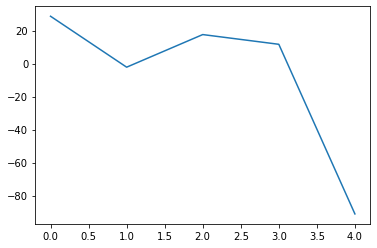

In [110]:
plt.figure()
x = range(len(rewards))
plt.plot(x, rewards)
plt.plot(x, rewards_df.rolling(25).mean())
plt.show()

In [32]:
# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format('prices'), overwrite=True)

In [44]:
# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=False)
# nb_max_start_steps=len(data)

Testing for 5 episodes ...
0.0 0.0 0.25711366403597635
Episode 1: reward: 0.000, steps: 480
0.0 0.0 0.0690193565124928
Episode 2: reward: 0.000, steps: 480
0.0 0.0 0.18532098627634874
Episode 3: reward: 0.000, steps: 480
0.0 0.0 0.18045677973299146
Episode 4: reward: 0.000, steps: 480
0.0 0.0 0.07139207628186894
Episode 5: reward: 0.000, steps: 480


In [43]:
import numpy as np

observation = env.reset()
while True:
    # action = env.action_space.sample()
    obs = np.expand_dims(np.expand_dims(observation, axis=1), axis=1)
    action = np.argmax(model.predict(obs))
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

-0.061778634946387356 0.5984803492999977
info: {'total_reward': -488.3899999999994, 'total_profit': 0.9382213650536126, 'position': 1}


IndexError: list index out of range

In [42]:
dqn

In [1]:
import functools

import numpy as np
import tensorflow as tf

In [66]:
model = tf.keras.models.Sequential(
    [
        #preprocessing_layer,
        #tf.keras.layers.Reshape((WINDOW_SIZE, len(select_columns))),
        tf.keras.layers.LayerNormalization(axis=1, center=True, scale=True),
        tf.keras.layers.LSTM(64,
                               return_sequences=True,),
                               #input_shape=(30, BATCH_SIZE)),
        tf.keras.layers.LSTM(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001, clipvalue=1.0), loss='mae')

In [67]:
model.fit(final_ds, verbose=1)

440/440 [==============================] - 16s 37ms/step - loss: 42.1479


In [65]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_normalization_5 (Layer multiple                  48        
_________________________________________________________________
lstm_22 (LSTM)               multiple                  7936      
_________________________________________________________________
lstm_23 (LSTM)               multiple                  3136      
_________________________________________________________________
dense_11 (Dense)             multiple                  17        
Total params: 11,137
Trainable params: 11,137
Non-trainable params: 0
_________________________________________________________________
